# **Conectando Colab con Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
import os
os.chdir('/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning')

# Denoising Autoencoders y donde encontrarlos

Hoy vamos a entrenar codificadores automáticos profundos y aplicarlos a la búsqueda de caras e imágenes similares.

Nuestros nuevos sujetos de prueba son rostros humanos de [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# **Importamos las librerias necesarias**

In [11]:
import sys
sys.path.append("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning")
import grading

In [12]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
#from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
import pandas as pd
import cv2
import tarfile
import tqdm_utils
#from keras_utils import reset_tf_session

In [13]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!

# **Cargando el dataset**
El conjunto de datos fue descargado por usted. Enlaces relevantes (por si acaso:
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [ ]:
# we downloaded them for you, just link them here
# download_utils.link_week_4_resources()

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
# Cargamos los dataset
ATTRS_NAME = '/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/datasets/lfw_attributes.txt'
IMAGES_NAME = '/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/datasets/lfw-deepfunneled.tgz'
RAW_IMAGES_NAME = '/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/datasets/lfw.tgz'

In [15]:
# Cargamos las imagenes con una dimension de 32x32
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

**************************************************



In [16]:
# X es un tensor con 13143 registros de 32x32 con 3 canales 
X.shape

(13143, 32, 32, 3)

In [17]:
# Visualizamos el dataset de caracteristicas
attr.head(5)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,-0.602662,-0.836360,0.909554,-2.039009,-0.937008,-0.520853,-0.399348,-0.609662,-0.328941,-1.200554,-0.390510,-2.734070,-1.519454,0.555006,-0.625682,-1.459263,-0.866737,-0.396046,0.551072,-0.986439,-0.073422,-0.564658,-1.161345,1.575632,0.965746,-0.607315,0.449310,0.668191,-0.405056,-0.613886,-0.167452,-2.544100,-0.586520,0.460766,0.009286,-0.830431,1.970265,0.488666,-0.047771,0.303884,-1.354266,0.930372,-1.712585,-0.298748,0.465369,0.794791,-0.450567,0.283735,-0.148479,1.279059,0.959224,-0.709500,-0.684215,2.319639,-0.858775,0.026684,-0.929809,-1.794659,0.094929,-0.567230,-1.070440,-1.528839,-1.406800,-0.793891,-1.772558,0.234426,-0.531727,-2.351688,0.092956,1.513827,-0.176601,-0.335991,-0.882286
1,0.505597,-1.914053,2.510250,-2.431401,-1.003366,-1.445389,-1.536998,-0.204474,0.487091,-1.747465,-0.311364,-0.063177,-0.957594,0.501207,0.221517,-1.757264,-0.551377,-0.282309,0.195253,-0.317791,-0.912739,-0.614058,0.645910,0.481944,-1.519334,0.566179,0.801907,-1.060695,0.901279,-1.347419,0.079716,0.268679,-0.467019,-1.304332,-0.991695,-0.050316,0.261866,0.334746,0.785039,1.269842,-1.254410,1.100479,-0.924761,-1.378957,0.800159,0.343087,0.276153,0.115633,0.761935,-0.668475,0.721088,-0.480292,-1.002982,3.991151,-0.345703,0.043164,-1.384257,-1.938046,0.393260,-0.749561,-0.329255,-0.579444,-0.234069,0.009661,-0.374216,-0.013630,-0.080964,-2.125320,0.281169,-1.241666,-0.515579,0.181500,-0.803750
2,1.403801,-1.396163,0.636715,-1.024909,-1.766047,-0.661043,-1.734535,-0.239029,0.350139,-1.670612,-0.239739,-1.025871,-0.669365,0.294301,-0.243044,-1.240407,-0.559538,0.900781,-0.864989,0.925484,-0.415565,0.477309,-0.963641,0.498012,0.737615,1.382718,-0.318062,-0.137686,0.824265,-0.209637,-0.138066,0.027229,-0.462200,-0.283984,-0.059173,-0.364826,1.323511,0.275434,1.303620,-0.126634,-0.596104,-0.337977,-0.486416,0.055621,-0.177267,0.375264,-0.448152,0.211282,0.641180,-1.230751,-1.004348,-0.264218,-0.173436,0.983262,-1.024046,-0.968107,-1.251581,-0.831154,-0.048752,1.873879,-1.285171,0.366453,-0.517039,1.114659,-0.503967,1.652175,-1.145252,-1.253068,0.874682,0.497179,-1.118230,0.719109,-0.163028
3,0.929768,-1.751162,2.347065,-2.242588,-1.358521,-0.902918,-1.872114,-0.348193,0.106553,-1.920013,-0.843878,-1.455269,0.116413,-0.008849,0.096805,-1.770558,-0.883169,0.251477,-0.222816,0.979753,-0.485323,-1.154412,-0.311130,-0.157736,-0.350956,0.950488,0.347889,-1.202525,1.600153,-0.130796,-0.173291,-0.149002,-0.510854,-0.382419,-1.094310,-0.205277,0.963489,0.853781,0.156086,0.312227,-1.821509,0.594445,-0.243877,-1.547460,0.089259,0.294815,-0.338663,0.035234,1.025987,-0.407141,-0.642350,-0.298058,-0.607125,2.073995,-0.076147,-0.790680,-1.323887,-1.593495,0.405241,0.768172,-1.272860,-1.302341,-0.816332,1.781297,-1.031062,0.705507,-1.682460,0.030410,0.303866,-0.996759,-0.562108,1.395046,-0.601105
4,1.382125,-1.838187,1.633984,-1.492228,-1.356108,-0.560854,-1.683840,-0.825507,0.886115,-0.712738,-0.661126,-1.245262,-0.791411,1.203552,0.023836,-0.901334,-0.807165,-1.228249,1.559711,0.280109,-1.603432,0.092141,-0.770683,1.271800,0.049786,0.109589,-0.910338,-1.045997,-0.147860,-0.723328,-0.195800,0.970945,

In [18]:
# Numero de columnas
len(attr.columns)

73

In [19]:
# Hallamos la forma del tensor IMG_SHAPE
IMG_SHAPE =X.shape[1:]

In [22]:
# Normalizamos
X = X.astype('float32') / 255.0 - 0.5

In [23]:
# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [24]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1519

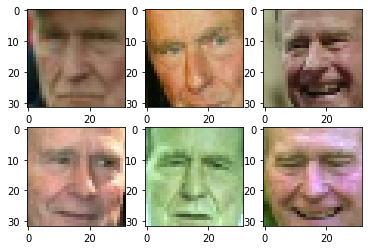

In [25]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# liberamos memoria
del X
import gc
gc.collect()

# **Arquitectura de los autoencoder**

Diseñemos el autoencoder como dos modelos secuenciales de keras: el codificador y el decodificador respectivamente.

Luego utilizaremos una API simbólica para aplicar y entrenar estos modelos.

![](https://drive.google.com/uc?export=view&id=1NxiaNNcbwzPS1xnB2M5EYRKlm1vO7W8k)

# **Primer paso: PCA**

Analisis de componentes principales es un método popular de reducción de dimensionalidad.

Under the hood, PCA intenta descomponer la matriz de objeto-característica
 $X$ en dos matrices más pequeñas: $W$ y $\hat W$ minimizando el  _error cuadratico medio_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - matriz objetivo (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matriz de tranformacion directa;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matriz de transformacion inversa;
- $n$ muestras, $m$ dimensiones originales y $d$ dimensiones objetivo;

En términos geométricos, queremos encontrar **d** ejes a lo largo de los cuales ocurre la mayor parte de la varianza. Los ejes "naturales", si lo desea.


![](https://drive.google.com/uc?export=view&id=1bxaYNe1GNg8USSHm9E9wyW8nfWClxQSn)


PCA también puede verse como un caso especial de un codificador automático.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Donde Dense es una capa completamente conectada con activación lineal:$f(X) = W \cdot X + \vec b $


Nota: el término de sesgo en esas capas es responsable de "centrar" la matriz, es decir, restar la media.


In [26]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))      # Preparamos la dimension de entrada(Capa de entrada)
    encoder.add(L.Flatten())                  # Aplanamos la imagen a vector
    encoder.add(L.Dense(code_size))           # Definimos el encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Combinandolos en un solo modelo:

In [27]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

In [28]:
inp = L.Input(IMG_SHAPE) # creamos el tensor con tamaño IMG_SHAPE
code = encoder(inp)
reconstruction = decoder(code)

In [29]:
# Combinamos
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)

In [30]:
# Compilamos
autoencoder.compile(optimizer='adamax', loss='mse')

In [31]:
# Entrenamos
autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                #callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=1)

Epoch 1/15
370/370 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.0000e+00
Epoch 2/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0000e+00
Epoch 3/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0000e+00
Epoch 4/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 5/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 6/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 7/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 8/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 9/15
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 10/15
370/370 [==============================] - 1s 3ms/st

In [32]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006532228086143732


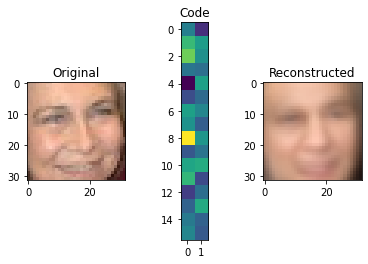

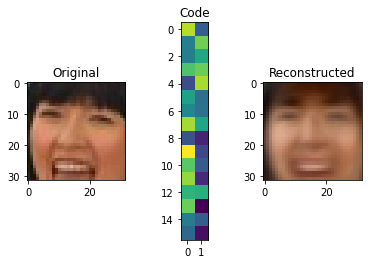

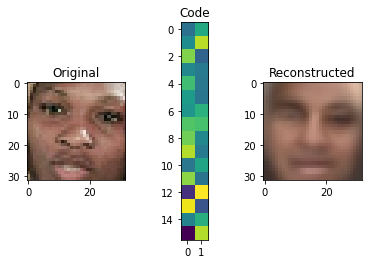

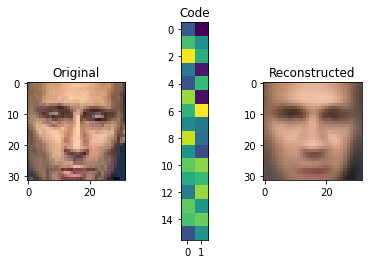

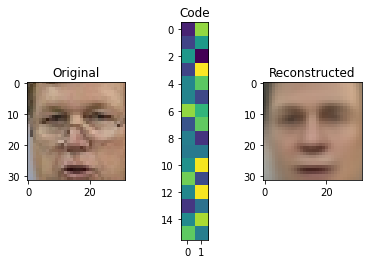

In [33]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# **Profundizando: autoencoder convolucional**

PCA es genial, pero seguramente podemos hacerlo mejor. Esta vez queremos que construyas un autoencoder convolucional profundo ... apilando más capas.


## **Encoder**

La parte **codificador** es bastante estándar, apilamos capas convolucionales y agrupadas y terminamos con una capa densa para obtener la representación del tamaño deseable
 (`code_size`).

Recomendamos usar `activation='elu'` para todas las capas convolucionales y densas.

Recomendamos repetir (conv, pool) 4 veces con el tamaño del kernel (3, 3), `padding='same'` y el siguiente número de canales de salida: `32, 64, 128, 256`.

Recuerda aplanar (`L.Flatten()`) salida antes de agregar la última capa densa!

## **Decoder**

Para **decodificador** usaremos la llamada "convolución de transposición". 

La capa convolucional tradicional toma un parche de una imagen y produce un número (parche -> número). En "transponer convolución" queremos tomar un número y producir un parche de una imagen (número -> parche). Necesitamos esta capa para "deshacer" las convoluciones en el codificador. Lo vimos durante la semana 3(watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Así es como funciona la "convolución de transposición":
![](https://drive.google.com/uc?export=view&id=1VOzbep42KGFMhg0CZ1UxEf93Krjx6y9M)
En este ejemplo usamos un paso de 2 para producir una salida 4x4, de esta manera también "deshacemos" la agrupación. Otra forma de pensarlo: "deshacemos" la convolución con el paso 2 (que es similar a conv + pool).

Puede agregar una capa de "transposición de convolución" en Keras así:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```
Nuestro decodificador comienza con una capa densa para "deshacer" la última capa del codificador. Recuerde remodelar su salida para "deshacer" `L.Flatten ()`en el codificador.


Ahora estamos listos para deshacer  los pares(conv, agrupación). Para esto necesitamos apilar 4 capas `L.Conv2DTranspose` con el siguiente número de canales de salida: `128, 64, 32, 3`. Cada una de estas capas aprenderá a "deshacer" (conv, agrupación) pares en el codificador. Por último en la capa
 `L.Conv2DTranspose` use `activation=None` porque esa es nuestra imagen final.

In [35]:
# Juguemos con la convolución de transposición en ejemplos primero
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    #s = reset_tf_session()
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    #result = s.run(conv)
    print("input:")
    print(x)
    print(x.shape)
    #print(x[0, :, :, 0])
    print("filter:")
    print(f)
    print(f.shape)
    print(f[:, :, 0, 0])
    print("output:")
    print(conv[0, :, :, 0])
    #s.close()
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[[[1.]
   [2.]]

  [[3.]
   [4.]]]]
(1, 2, 2, 1)
filter:
[[[[1.]]

  [[1.]]]


 [[[1.]]

  [[1.]]]]
(2, 2, 1, 1)
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=2, filter_size=3:
input:
[[[[1.]
   [2.]]

  [[3.]
   [4.]]]]
(1, 2, 2, 1)
filter:
[[[[1.]]

  [[1.]]

  [[1.]]]


 [[[1.]]

  [[1.]]

  [[1.]]]


 [[[1.]]

  [[1.]]

  [[1.]]]]
(3, 3, 1, 1)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=4, filter_size=2:
input:
[[[[ 1.]
   [ 2.]
   [ 3.]
   [ 4.]]

  [[ 5.]
   [ 6.]
   [ 7.]
   [ 8.]]

  [[ 9.]
   [10.]
   [11.]
   [12.]]

  [[13.]
   [14.]
   [15.]
   [16.]]]]
(1, 4, 4, 1)
filter:
[[[[1.]]

  [[1.]]]


 [[[1.]]

  [[1.]]]]
(2, 2, 1, 1)
[[1

In [36]:
# Parte 1 - Construir el modelo de CNN

# Importar las librerías y paquetes
from keras.models import Sequential
from keras.layers import Conv2D         # Creamos capas de convolucion 2D.( Extraccion de las mejores caracteristicas de la imagen)
from keras.layers import MaxPooling2D   # Creamos capas de reduccion. ( Reduce dimension y aprende rasgos mas interesantes)
from keras.layers import Flatten        # Aplanado u ordenamiento de los datos. ( Lo convierte a matriz columna)
from keras.layers import Dense          # Creamos la conexion entre las capas de redes totalmente conectadas.

In [37]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size = (2,2)))
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size = (2,2)))
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size = (2,2)))
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation='elu', padding='same'))
    encoder.add(MaxPooling2D(pool_size = (2,2)))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))           

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))

    # New size -> tamaño del pooling* numero de filtros
    new_img_shape = 2*2*256
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(new_img_shape))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [38]:
# Comprobamos la formas del autoencoder a lo largo de diferentes tamaños de codigos(tamaño final de la imagen en la etapa de comprension)
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    #s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("Exito!")
#s = reset_tf_session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Exito!


In [39]:
# Numero de parametros del encoder y decoder debe ser casi iguales
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)       

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [40]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32) # Code size igual a 32 ya que son las dimensiones originales de la imagen

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [41]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
#last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [59]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                #callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           #keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Epoch 1/25
370/370 [==============================] - 62s 168ms/step - loss: 0.0123 - val_loss: 0.0000e+00
Epoch 2/25
370/370 [==============================] - 64s 173ms/step - loss: 0.0082 - val_loss: 0.0000e+00
Epoch 3/25
370/370 [==============================] - 61s 164ms/step - loss: 0.0073 - val_loss: 0.0000e+00
Epoch 4/25
370/370 [==============================] - 61s 165ms/step - loss: 0.0071 - val_loss: 0.0000e+00
Epoch 5/25
370/370 [==============================] - 61s 164ms/step - loss: 0.0069 - val_loss: 0.0000e+00
Epoch 6/25
370/370 [==============================] - 61s 166ms/step - loss: 0.0069 - val_loss: 0.0000e+00
Epoch 7/25
370/370 [==============================] - 62s 167ms/step - loss: 0.0068 - val_loss: 0.0000e+00
Epoch 8/25
370/370 [==============================] - 62s 167ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 9/25
370/370 [==============================] - 62s 168ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 10/25
370/370 [================

Convolutional autoencoder MSE en test : 0.005697672720998526


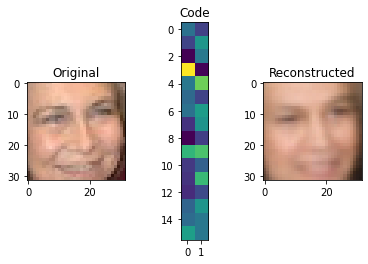

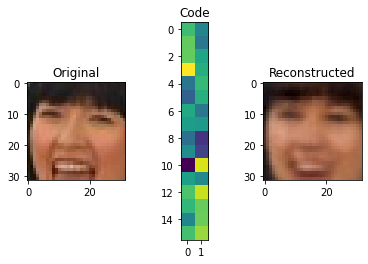

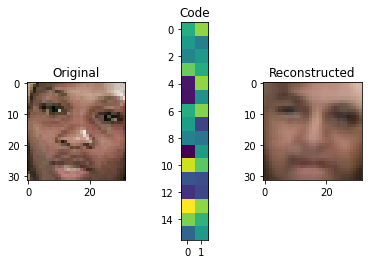

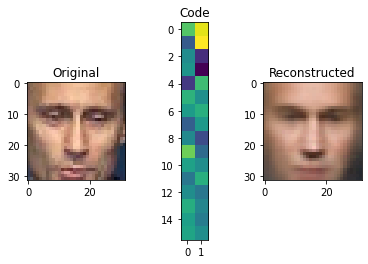

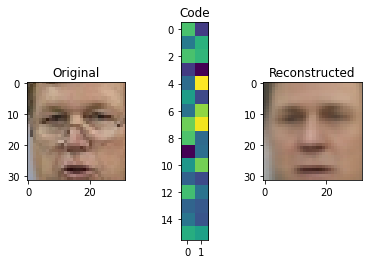

In [60]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE en test :", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [62]:
# Guardamos los pesos entrenados
encoder.save_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/encoder.h5")
decoder.save_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/decoder.h5")

In [43]:
# Cargamos los pesos entrenados

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/encoder.h5")
decoder.load_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))

0.005697672720998526


# **Submit to Coursera**

In [64]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(IMG_SHAPE, code_size=71)

# token expires every 30 min
COURSERA_TOKEN = 'bRoflgcZRXEwO1Yu'
COURSERA_EMAIL = 'rguerreroh@uni.pe'

submit_autoencoder(submission, reconstruction_mse, COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Optional: Denoising Autoencoder

Esta parte es opcional, le muestra una aplicación útil de los autoencoder: eliminación de ruido. Puede ejecutar este código y asegurarse de que la eliminación de ruido funcione :)

Convirtamos ahora nuestro modelo en un autoencoder de eliminación de ruido:
![](https://drive.google.com/uc?export=view&id=1W2h0_KEM8sjzD0p4Hd4OTYqwet6bAHQ2)

Mantendremos la arquitectura del modelo, pero cambiaremos la forma en que se entrena. En particular, corromperemos sus datos de entrada aleatoriamente con ruido antes de cada época.

Hay muchas estrategias para introducir ruido: agregar ruido blanco gaussiano, ocluir con rectángulos negros aleatorios, etc. Agregaremos ruido blanco gaussiano.

In [44]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """

    ### YOUR CODE HERE ###
    noise = np.random.normal(0,sigma,X.shape)
    return X + noise

In [45]:
# testeando los ruidos
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01 # Debemos usar sigma como estandar
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01 # Media ha cambiado añadir ruido con media 0

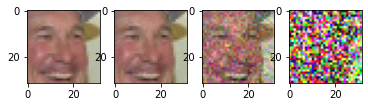

In [46]:
# probar diferentes escalas de ruidos
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Entrenando por **1 hour**.

In [47]:
# Haremos que el tamaño final del encoder sea mas grande para tener mejor calidad!
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,) #encoder debe generar un codigo del tamaño requerido

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25): # Generamos nuevos datos con ruido
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # Entrenamos el modelo con nuevos datos con ruido
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    #callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=1)

Epoch 1/25, Generating corrupted samples...
370/370 [==============================] - 6s 15ms/step - loss: 0.0119 - val_loss: 0.0000e+00
Epoch 2/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 3/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0059 - val_loss: 0.0000e+00
Epoch 4/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0052 - val_loss: 0.0000e+00
Epoch 5/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0047 - val_loss: 0.0000e+00
Epoch 6/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0044 - val_loss: 0.0000e+00
Epoch 7/25, Generating corrupted samples...
370/370 [==============================] - 5s 14ms/step - loss: 0.0042 - val_loss: 0.0000e+00
Epoch 8/25, Generating corrupted s

Denoising MSE: 0.002892069285735488


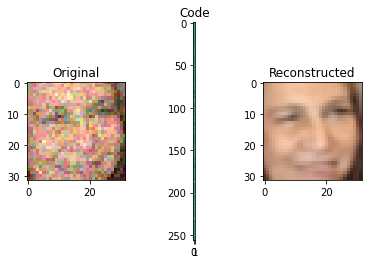

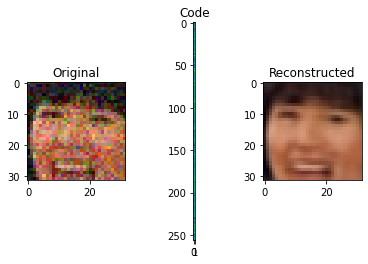

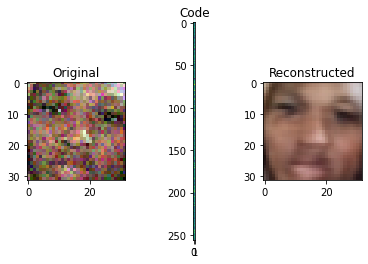

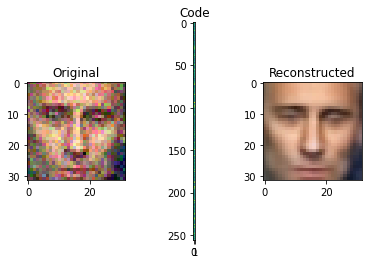

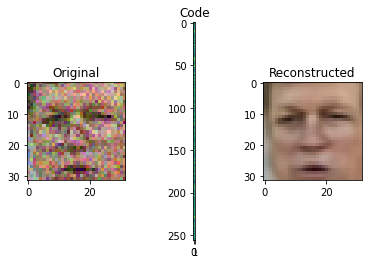

In [48]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# **Optional: Image retrieval with autoencoders**

Así que acabamos de entrenar una red que convierte la imagen en sí misma de manera imperfecta. Esta tarea no es tan útil en sí misma, pero tiene una serie de efectos secundarios asombrosos. Veámoslos en acción.

Lo primero que podemos hacer es recuperar imágenes, también conocido como búsqueda de imágenes. Le daremos una imagen y encontraremos imágenes similares en el espacio latente:

![](https://drive.google.com/uc?export=view&id=14OSBbxLLHB4Z96rGDWbURjKLEkfDHXAb)

Para acelerar el proceso de recuperación, se debe usar Hash sensible a la localidad en la parte superior de los vectores codificados. Esta [tecnica](  https://erikbern.com/2015/07/04 benchmark-of-approximate-nearest-neighbor-libraries.html) 
puede reducir los posibles vecinos más cercanos de nuestra imagen en el espacio latente (código del encoder). Calcularemos a los vecinos más cercanos en forma de fuerza bruta para simplificar.


In [52]:
# cargamos los pesos del encoder
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/encoder.h5")

In [53]:
X_train.shape

(11828, 32, 32, 3)

In [54]:
images = X_train
### YOUR CODE HERE: encode all images ###
codes = encoder.predict(images)
assert len(codes) == len(images)

In [59]:
codes[0].shape

(32,)

In [60]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [61]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [62]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

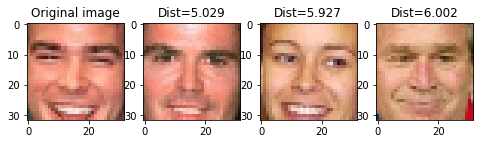

In [63]:
# smiles
show_similar(X_test[247])

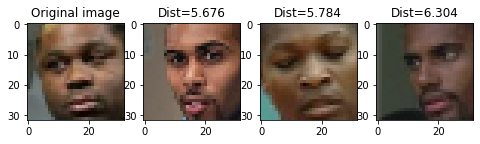

In [64]:
# ethnicity
show_similar(X_test[56])

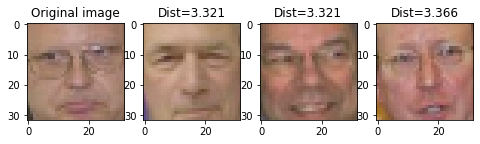

In [65]:
# glasses
show_similar(X_test[63])

# **Opcional: transformación de imagen**


Podemos tomar combinaciones lineales de códigos de imagen para producir nuevas imágenes con decodificador!!


In [68]:
# Cragamos los pesos
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/encoder.h5")
decoder.load_weights("/content/gdrive/My Drive/Programacion/Python/Machine Learning avanzado/1.Introduccion al Deep Learning/Semana4/Evaluacion/decoder.h5")

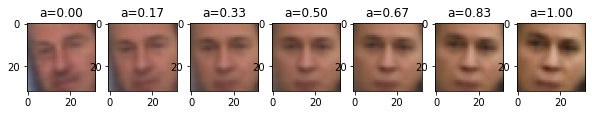

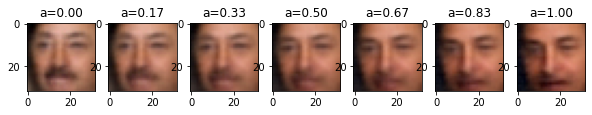

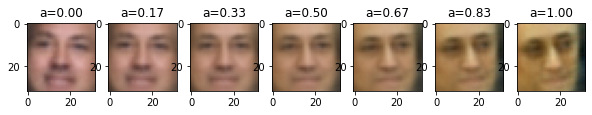

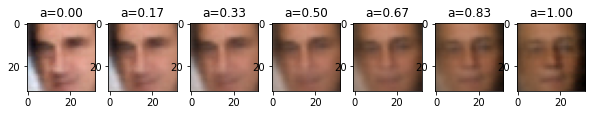

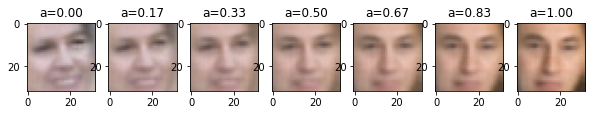

In [71]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

¡Eso es!

Por supuesto, puede hacer mucho más con los codificadores automáticos.

Sin embargo, si desea generar imágenes desde cero, le recomendamos nuestra pista de honor en Generative Adversarial Networks o GAN.

# **Anexos**

In [8]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [9]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs.columns = list(df_attrs.columns)[1:] + ["NaN"]
    df_attrs = df_attrs.drop("NaN", axis=1)
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_utils.tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs